In [1]:
# Copyright (C) 2017 Zhixian MA <zxma_sjtu@qq.com>

# Do MNIST feature learning by our code agn-ae

In [2]:
import numpy as np
import matplotlib
matplotlib.use('Agg') # Change matplotlib backend, in case we have no X server running..
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image as IPImage
from PIL import Image

import sys   
sys.setrecursionlimit(1000000)

In [3]:
from ConvAE import ConvAE
import utils

Using gpu device 0: GeForce GT 730 (CNMeM is disabled, cuDNN 5105)


In [4]:
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne import PrintLayerInfo

In [5]:
# load data
import pickle
fname = 'mnist/mnist.pkl'
fp = open(fname, 'rb')
train,valid,test = pickle.load(fp,encoding='latin1')
fp.close()

In [6]:
X_train, y_train = train
X_test, y_test = test
# randomly select 10000 samples

print('X_train type and shape:', X_train.dtype, X_train.shape)
print('X_train.min():', X_train.min())
print('X_train.max():', X_train.max())

print('X_test type and shape:', X_test.dtype, X_test.shape)
print('X_test.min():', X_test.min())
print('X_test.max():', X_test.max())

X_train type and shape: float32 (50000, 784)
X_train.min(): 0.0
X_train.max(): 0.996094
X_test type and shape: float32 (10000, 784)
X_test.min(): 0.0
X_test.max(): 0.996094


In [7]:
# define the net
idx = np.random.permutation(X_train.shape[0])
X = X_train[idx[0:20000],:]
X_in = X.reshape(-1,1,28,28)
X_out = X
kernel_size = [5, 5]
kernel_num = [16, 16]
pool_flag = [True, True]
fc_nodes = [128]
encode_nodes = 16
net = ConvAE(X_in=X_in, X_out=X_out, kernel_size=kernel_size, pool_flag=pool_flag,
             kernel_num=kernel_num, fc_nodes=fc_nodes, encode_nodes = 16)

In [8]:
# generate layers
net.gen_layers()
net.layers

[(lasagne.layers.input.InputLayer, {'shape': (None, 1, 28, 28)}),
 (lasagne.layers.conv.Conv2DLayer,
  {'filter_size': 5, 'num_filters': 16, 'pad': 'valid'}),
 (lasagne.layers.pool.MaxPool2DLayer, {'pool_size': 2}),
 (lasagne.layers.conv.Conv2DLayer,
  {'filter_size': 5, 'num_filters': 16, 'pad': 'valid'}),
 (lasagne.layers.pool.MaxPool2DLayer, {'pool_size': 2}),
 (lasagne.layers.shape.ReshapeLayer, {'shape': ([0], -1)}),
 (lasagne.layers.dense.DenseLayer, {'num_units': 128}),
 (lasagne.layers.dense.DenseLayer, {'name': 'encode', 'num_units': 16}),
 (lasagne.layers.dense.DenseLayer, {'num_units': 128}),
 (lasagne.layers.dense.DenseLayer, {'num_units': 256}),
 (lasagne.layers.shape.ReshapeLayer, {'shape': ([0], 16, 4, 4)}),
 (lasagne.layers.pool.Upscale2DLayer, {'scale_factor': 2}),
 (lasagne.layers.conv.Conv2DLayer,
  {'filter_size': 5, 'num_filters': 16, 'pad': 'full'}),
 (lasagne.layers.pool.Upscale2DLayer, {'scale_factor': 2}),
 (lasagne.layers.conv.Conv2DLayer,
  {'filter_size': 5,

In [9]:
# Build the network and initilization
net.cae_build(learning_rate=0.01, momentum=0.975, verbose=2)

In [10]:
# Train the network
net.cae_train()

Training the network...
# Neural Network with 83809 learnable parameters

## Layer information

name         size        total    cap.Y    cap.X    cov.Y    cov.X
-----------  --------  -------  -------  -------  -------  -------
input0       1x28x28       784   100.00   100.00   100.00   100.00
conv2d1      16x24x24     9216   100.00   100.00    17.86    17.86
maxpool2d2   16x12x12     2304   100.00   100.00    17.86    17.86
conv2d3      16x8x8       1024    76.92    76.92    46.43    46.43
maxpool2d4   16x4x4        256    76.92    76.92    46.43    46.43
reshape5     256           256   100.00   100.00   100.00   100.00
dense6       128           128   100.00   100.00   100.00   100.00
encode       16             16   100.00   100.00   100.00   100.00
dense8       128           128   100.00   100.00   100.00   100.00
dense9       256           256   100.00   100.00   100.00   100.00
reshape10    16x4x4        256   100.00   100.00   100.00   100.00
upscale2d11  16x8x8       1024   

In [11]:
# save result
net.cae_save('mnist/net.pkl')

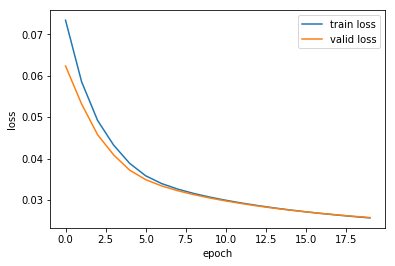

In [12]:
# Plot the loss curve
net.cae_eval()

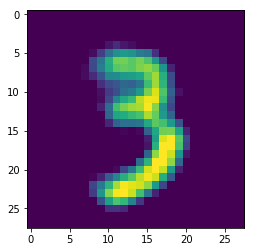

In [13]:
# from imp import reload
# reload(utils)
# Test the network
imgs = X_test.reshape(-1,28,28)
img_small = imgs[30,:,:]

# encode
img_en = utils.get_encode(net.cae, img_small)
# decode
img_de = utils.get_decode(net.cae, img_en)

# Compare
img_pre = np.rint(img_de.reshape(28,28) * 256).astype(int)
img_pre = np.clip(img_pre, a_min = 0, a_max = 255)
img_pre = img_pre.astype('uint8')
plt.imshow(img_pre)

# img_pre = utils.get_predict(net.cae, img_small)

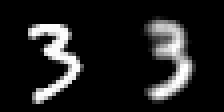

In [14]:
def get_picture_array(X, rescale=4):
    array = X.reshape(28,28)
    array = np.clip(array, a_min = 0, a_max = 255)
    return  array.repeat(rescale, axis = 0).repeat(rescale, axis = 1).astype(np.uint8())

def compare_images(img, img_pre):
    original_image = Image.fromarray(get_picture_array(255 * img))
    new_size = (original_image.size[0] * 2, original_image.size[1])
    new_im = Image.new('L', new_size)
    new_im.paste(original_image, (0,0))
    rec_image = Image.fromarray(get_picture_array(img_pre))
    new_im.paste(rec_image, (original_image.size[0],0))
    new_im.save('mnist/test.png', format="PNG")
    return IPImage('mnist/test.png')

compare_images(img_small, img_pre)

<module 'matplotlib.pyplot' from '/home/mzx/work/deeplearning/convolutional_autoencoder/env/lib/python3.4/site-packages/matplotlib/pyplot.py'>

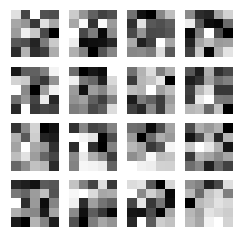

In [15]:
plot_conv_weights(net.cae.layers_[1], figsize=(4,4))

In [16]:
netInfo = PrintLayerInfo()
netInfo(net.cae)

# Neural Network with 83809 learnable parameters

## Layer information

name         size        total    cap.Y    cap.X    cov.Y    cov.X
-----------  --------  -------  -------  -------  -------  -------
input0       1x28x28       784   100.00   100.00   100.00   100.00
conv2d1      16x24x24     9216   100.00   100.00    17.86    17.86
maxpool2d2   16x12x12     2304   100.00   100.00    17.86    17.86
conv2d3      16x8x8       1024    76.92    76.92    46.43    46.43
maxpool2d4   16x4x4        256    76.92    76.92    46.43    46.43
reshape5     256           256   100.00   100.00   100.00   100.00
dense6       128           128   100.00   100.00   100.00   100.00
encode       16             16   100.00   100.00   100.00   100.00
dense8       128           128   100.00   100.00   100.00   100.00
dense9       256           256   100.00   100.00   100.00   100.00
reshape10    16x4x4        256   100.00   100.00   100.00   100.00
upscale2d11  16x8x8       1024   100.00   100.00   100.00

In [17]:
# from nolearn.lasagne.visualize import draw_to_notebook
# draw_to_notebook(net.cae)

Concating the maps
montage -mode concatenate -tile 4x mnist/C1/*.png mnist/C1/map_con.png


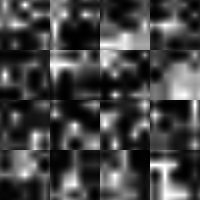

In [18]:
from imp import reload
reload(utils)
utils.get_concate(net.cae, layer_idx=1, savefolder='mnist/C1')
IPImage('mnist/C1/map_con.png')

Concating the maps
montage -mode concatenate -tile 4x mnist/C2/*.png mnist/C2/map_con.png


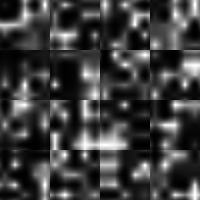

In [19]:
utils.get_concate(net.cae, layer_idx=3, savefolder='mnist/C2')
IPImage('mnist/C2/map_con.png')

Concating the convolved maps
montage -mode concatenate -tile 4x mnist/conv1/*.png mnist/conv1/conv_con.png


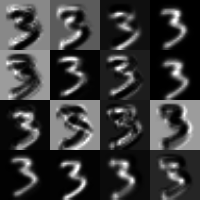

In [20]:
img_conv = utils.get_conv(net.cae, layer_idx=1, img=img_small, savefolder='mnist/conv1')
IPImage('mnist/conv1/conv_con.png')

Concating the convolved maps
montage -mode concatenate -tile 4x mnist/conv2/*.png mnist/conv2/conv_con.png


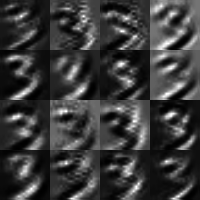

In [21]:
img_conv = utils.get_conv(net.cae, layer_idx=3, img=img_conv[0,:,:], savefolder='mnist/conv2')
IPImage('mnist/conv2/conv_con.png')